In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import plot_tree

from sklearn.inspection import permutation_importance

## Data preparation

In [2]:
df = pd.read_csv('data/Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# df = df[~((df['churn']==1)&(df['active_member']==1))]
X = df.drop(columns=['churn', 'customer_id', 'active_member'])
y = df['churn']

In [4]:
y.value_counts()

0    7963
1    2037
Name: churn, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111, shuffle=True, stratify=y)

In [6]:
y_train.value_counts()

0    5335
1    1365
Name: churn, dtype: int64

In [7]:
y_test.value_counts()

0    2628
1     672
Name: churn, dtype: int64

In [8]:
enc = OneHotEncoder(handle_unknown='ignore', drop='if_binary')
X_train_oh = enc.fit_transform(X_train[['country', 'gender']])
X_test_oh = enc.transform(X_test[['country', 'gender']])

column_name = enc.get_feature_names_out(['country', 'gender'])
X_train_oh = pd.DataFrame(X_train_oh.toarray(), columns=column_name, index=X_train.index)
X_test_oh = pd.DataFrame(X_test_oh.toarray(), columns=column_name, index=X_test.index)

X_train_num =  pd.concat([X_train.drop(columns=['country', 'gender']), X_train_oh], axis=1)
X_test_num =  pd.concat([X_test.drop(columns=['country', 'gender']), X_test_oh], axis=1)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

## Train

### Logistic Regression

In [10]:
clf_lr = LogisticRegression(random_state=111, C=1, class_weight='balanced')
clf_lr.fit(X_train_scaled, y_train)

y_pred_lr = clf_lr.predict(X_test_scaled)

In [11]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.89      0.70      0.79      2628
           1       0.37      0.67      0.47       672

    accuracy                           0.70      3300
   macro avg       0.63      0.69      0.63      3300
weighted avg       0.78      0.70      0.72      3300



In [12]:
confusion_matrix(y_test, y_pred_lr)

array([[1851,  777],
       [ 224,  448]])

In [13]:
df_odds = pd.DataFrame({
    'feature_name' : X_train_num.columns,
    'odds' : np.exp(clf_lr.coef_[0]).round(2),
    'std' : X_train_num.std().round(2) # we standarsied our features so change by 1 means changeby 1std
})

df_odds.sort_values('odds', ascending=False)

,feature_name,odds,std
age,age,2.25,10.45
country_Germany,country_Germany,1.28,0.43
balance,balance,1.17,62240.55
credit_card,credit_card,1.02,0.46
estimated_salary,estimated_salary,1.00,57691.66
tenure,tenure,0.96,2.88
products_number,products_number,0.94,0.58
credit_score,credit_score,0.91,96.70
country_Spain,country_Spain,0.91,0.43
country_France,country_France,0.88,0.50


#### Test it
By changing by 1std (or 2std in case of categorical features) one example

In [203]:
X_test_i = pd.DataFrame(X_test_num.iloc[0,:].copy()).T
X_test_i

,credit_score,age,tenure,balance,products_number,credit_card,estimated_salary,country_France,country_Germany,country_Spain,gender_Male
5910,481.0,39.0,6.0,0.0,1.0,1.0,24677.54,1.0,0.0,0.0,0.0


In [204]:
y_pred_i_list = []
X_test_i_actions = []

In [205]:
X_test_i_scaled = scaler.transform(X_test_i)
y_pred_i = clf_lr.predict_proba(X_test_i_scaled)[:,1]
y_pred_i_list.append(y_pred_i[0])
X_test_i_actions.append('baseline')
y_pred_i

array([0.47417438])

In [206]:
X_test_i['age'] = X_test_i['age'] + 10

X_test_i_scaled = scaler.transform(X_test_i)
y_pred_i = clf_lr.predict_proba(X_test_i_scaled)[:,1]
y_pred_i_list.append(y_pred_i[0])
X_test_i_actions.append(f"age +10\n(age:{X_test_i['age'].values[0]})")
y_pred_i

array([0.66161855])

In [207]:
X_test_i['gender_Male'] = 1

X_test_i_scaled = scaler.transform(X_test_i)
y_pred_i = clf_lr.predict_proba(X_test_i_scaled)[:,1]
y_pred_i_list.append(y_pred_i[0])
X_test_i_actions.append('gender\nFemale -> Male')
y_pred_i

array([0.52958842])

In [208]:
X_test_i['country_Germany'] = 1
X_test_i['country_France'] = 0

X_test_i_scaled = scaler.transform(X_test_i)
y_pred_i = clf_lr.predict_proba(X_test_i_scaled)[:,1]
y_pred_i_list.append(y_pred_i[0])
X_test_i_actions.append('country\nFrance -> Germany')
y_pred_i

array([0.72278894])

In [209]:
X_test_i['age'] = X_test_i['age'] + 10

X_test_i_scaled = scaler.transform(X_test_i)
y_pred_i = clf_lr.predict_proba(X_test_i_scaled)[:,1]
y_pred_i_list.append(y_pred_i[0])
X_test_i_actions.append(f"age +10\n(age:{X_test_i['age'].values[0]})")
y_pred_i

array([0.84969973])

In [210]:
y_pred_i_list.append(y_pred_i_list[-1])
X_test_i_actions.append(" ")

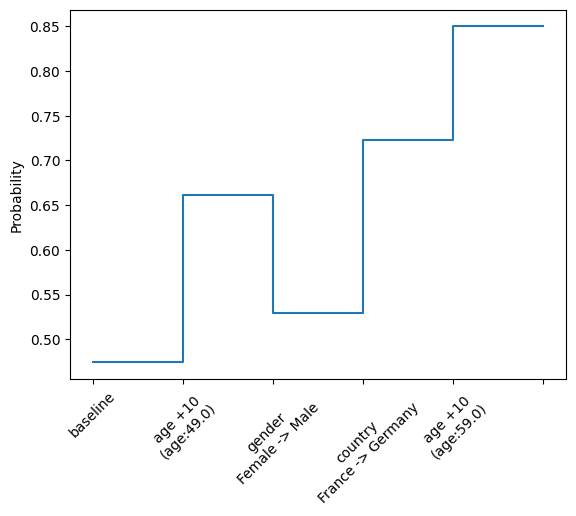

In [211]:
plt.step(np.arange(len(y_pred_i_list)), y_pred_i_list, where='post')

plt.xticks(np.arange(len(y_pred_i_list)), X_test_i_actions, rotation=45)

plt.ylabel('Probability')

plt.show()

In [212]:
y_arr = np.array(y_pred_i_list)
y_arr = y_arr/(1-y_arr)

In [213]:
# increase age 2.25 (1std)
# increase Male to 1 (so 2std)
# decrease FRance and ancrease Germany (2std up and 2std down)
# increase age 2.25 (1std)
odds_arr = np.array([2.25, 0.76*0.76, 1.28*1.28/0.88/0.88, 2.25])

In [219]:
# expected changes in ratio
y_expect = y_arr[:-2] * odds_arr
y_expect

array([2.02898515, 1.12934935, 2.38185367, 5.86655921])

In [220]:
# real changes in ratio
y_arr[1:-1]

array([1.95524473, 1.12579803, 2.60735965, 5.6533479 ])

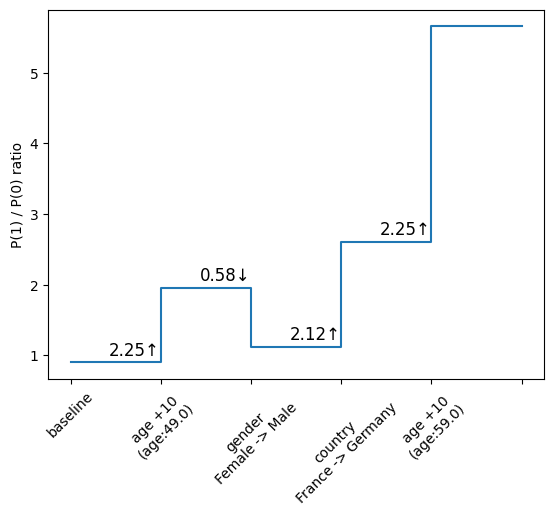

In [224]:
plt.step(np.arange(y_arr.shape[0]), y_arr, where='post')

plt.xticks(np.arange(y_arr.shape[0]), X_test_i_actions, rotation=45)

for (i, j, num) in zip(np.arange(1,5)-0.01, y_arr[:-2]+0.1, odds_arr):
    if num > 1:
        plt.text(i, j, f'{num:.2f}↑', fontsize=12, ha='right')
    else:
        plt.text(i, j, f'{num:.2f}↓', fontsize=12, ha='right')

plt.ylabel('P(1) / P(0) ratio')

plt.show()

### Decision Tree Classifier

In [288]:
clf_dt = DecisionTreeClassifier(random_state=111, max_depth=5, max_leaf_nodes=7, class_weight='balanced')

clf_dt.fit(X_train_num, y_train)

y_pred_dt = clf_dt.predict(X_test_num)

In [289]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      2628
           1       0.48      0.65      0.55       672

    accuracy                           0.79      3300
   macro avg       0.69      0.74      0.71      3300
weighted avg       0.82      0.79      0.80      3300



In [290]:
confusion_matrix(y_test, y_pred_dt)

array([[2153,  475],
       [ 234,  438]])

#### Feature importances (information gain)

In [291]:
df_imp_dt = pd.DataFrame({
    'feature_name' : X_train_num.columns,
    'feature_importance' : clf_dt.feature_importances_
})

df_imp_dt.sort_values('feature_importance', ascending=False)

,feature_name,feature_importance
1,age,0.505697
4,products_number,0.436506
3,balance,0.057797
0,credit_score,0.000000
2,tenure,0.000000
5,credit_card,0.000000
6,estimated_salary,0.000000
7,country_France,0.000000
8,country_Germany,0.000000
9,country_Spain,0.000000


#### Visualisation fo tree

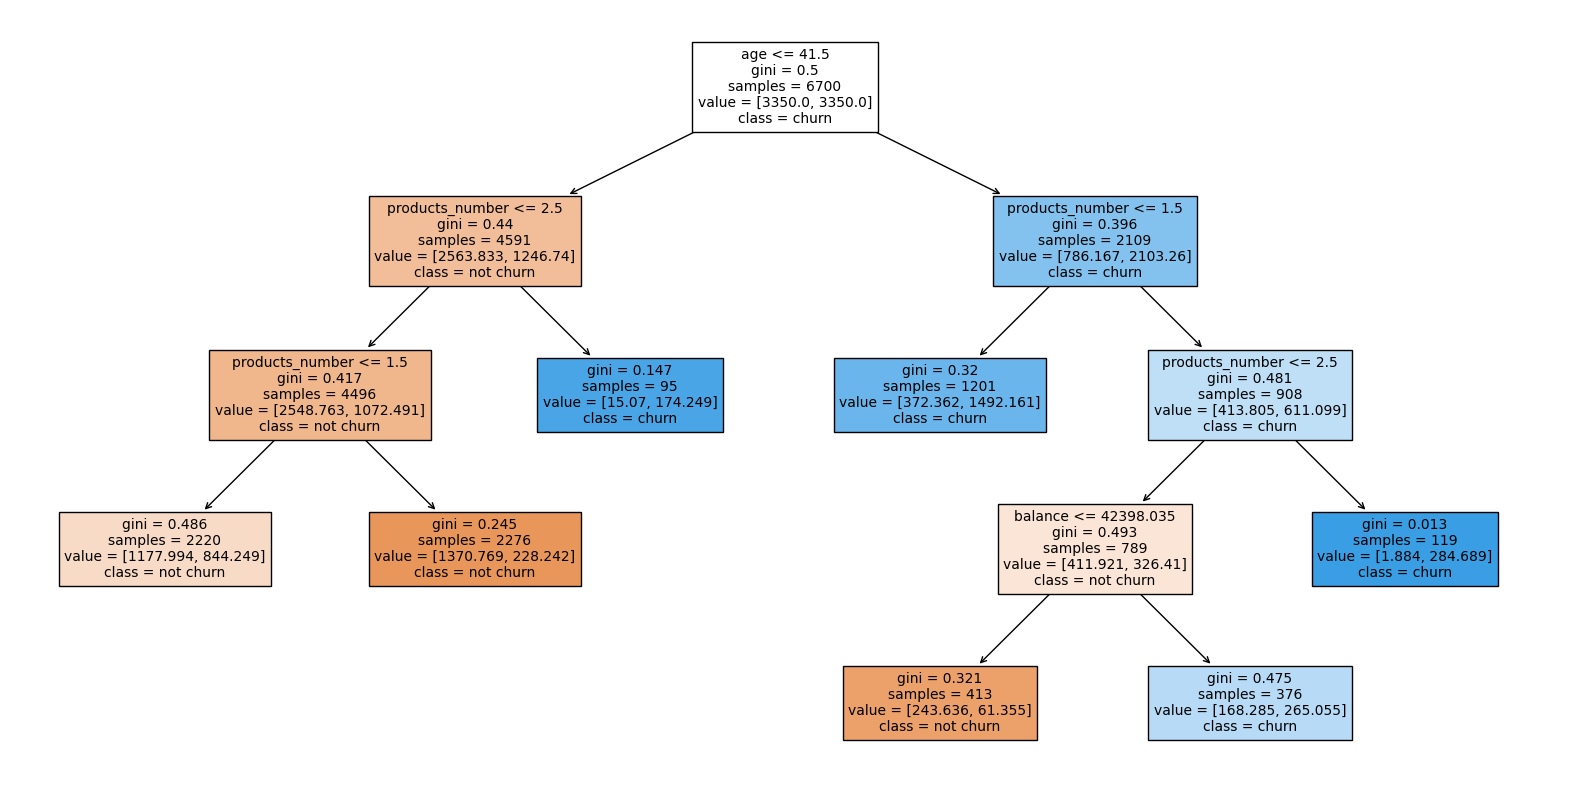

In [292]:
plt.figure(figsize=(20,10))
plot_tree(clf_dt, filled=True, feature_names=X_train_num.columns, class_names=['not churn', 'churn'], fontsize=10)
plt.show()

### Random Forest Classifier

In [293]:
clf_rf = RandomForestClassifier( 
    class_weight='balanced', n_estimators=200, 
    max_depth=10, random_state=111,
    min_samples_leaf=5
) 

clf_rf.fit(X_train_num, y_train)

y_pred_rf = clf_rf.predict(X_test_num)

In [294]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      2628
           1       0.52      0.67      0.59       672

    accuracy                           0.81      3300
   macro avg       0.71      0.76      0.73      3300
weighted avg       0.83      0.81      0.82      3300



In [295]:
confusion_matrix(y_test, y_pred_rf)

array([[2208,  420],
       [ 219,  453]])

#### Feature importances (information gain)

In [296]:
df_imp_rf = pd.DataFrame({
    'feature_name' : X_train_num.columns,
    'feature_importance' : clf_rf.feature_importances_
})

df_imp_rf.sort_values('feature_importance', ascending=False)

,feature_name,feature_importance
1,age,0.354548
4,products_number,0.213409
3,balance,0.125701
6,estimated_salary,0.078733
0,credit_score,0.076184
8,country_Germany,0.047161
2,tenure,0.042272
10,gender_Male,0.026289
7,country_France,0.016251
5,credit_card,0.009819


#### Permutation importances

In [297]:
result = permutation_importance(clf_rf, X_test_num, y_test, n_repeats=10, random_state=42, n_jobs=-1)

In [298]:
df_imp_rf_permut = pd.DataFrame({
    'feature_name' : X_test_num.columns,
    'feature_importance' : result.importances_mean
})

df_imp_rf_permut.sort_values('feature_importance', ascending=False)

,feature_name,feature_importance
4,products_number,0.077000
1,age,0.075515
3,balance,0.013879
10,gender_Male,0.004030
0,credit_score,0.001152
2,tenure,0.000455
8,country_Germany,-0.000061
6,estimated_salary,-0.000545
9,country_Spain,-0.000697
5,credit_card,-0.001545
